In [1]:
# NUMPY
import numpy as np
np.random.seed(3946)
# MATPLOTLIB
import matplotlib.pyplot as plt
plt.style.context('dark_background')
%matplotlib inline 
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 8, # 12
          'font.size': 8, # 12
          'legend.fontsize': 8, # 12
          'xtick.labelsize': 8, # 10
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (16, 6)}
plt.rcParams.update(params)

# SEABORN 
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

# SKLEARN 
from sklearn.metrics import pairwise_distances

# POT
import ot
from ot import sinkhorn, emd
# from ot.bregman import sinkhorn, greenkhorn

# PATH 
import sys
path_files = '/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/'
sys.path.insert(0, path_files) 

# GREENKHORN 
# from greenkhorn.sinkhorn import sinkhorn as sinkhgreen
# SCREENKHORN
# from screenkhorn.screenkhorn import Screenkhorn
from screenkhorn.screenkhorn_bis import Screenkhorn

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from time import time

## Data generation

In [2]:
n_1 = 200# nb samples
n_2 = 100
mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n_1, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n_2, mu_t, cov_t)

a = np.ones((n_1,)) / n_1
b = np.ones((n_2,)) / n_2  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()
reg = 1.

K = np.exp(-M/reg)

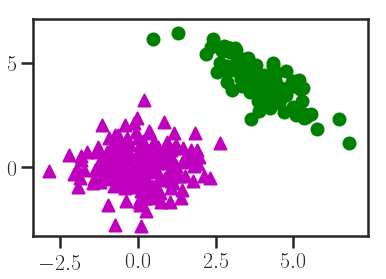

In [3]:
# plt.scatter(xs[:,0], xs[:,1], marker='^', c='m')
# plt.scatter(xt[:,0], xt[:,1], marker='o', c='g');

## Sinkhorn's algorithm from POT

In [4]:
tic = time()
P_sink = sinkhorn(a, b, M, reg, log=True)

# Print P^star, u_sink = e^{u^star}, v_sink = e^{v^star}
P_star = P_sink[0]
outputs_dict = P_sink[1]
exp_u_star = outputs_dict['u']
exp_v_star = outputs_dict['v']
time_sink = time() - tic
time_sink

0.004457950592041016

## Plots of $e^{u^\star}$ and $e^{v^\star}$ 

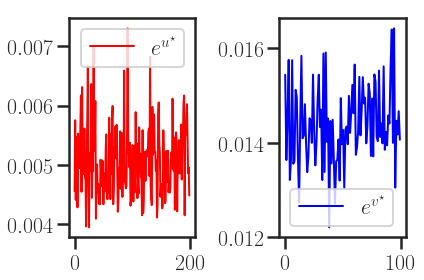

In [5]:
figure, axes= plt.subplots(nrows=1, ncols=2)

axes[0].plot(exp_u_star, linewidth=2, color='r', label=r'$e^{u^\star}$')
axes[1].plot(exp_v_star, linewidth=2, color='b', label=r'$e^{v^\star}$')
axes[0].legend()
axes[1].legend()
plt.subplots_adjust(hspace=.5)
plt.tight_layout()

### Plots of $u^\star$ and $v^\star$

## Choosing of the intervals $I_u$ and $J_v$

In [62]:
epsilon = 0.0003

I_active = np.where(a >= epsilon** 2 * K.sum(axis=1))[0].tolist()
J_active = np.where(b >= epsilon** 2 * K.T.sum(axis=1))[0].tolist()

In [63]:
len(I_active), len(J_active)

(200, 100)

# `screenkhorn`

In [51]:
screenkhorn = Screenkhorn(a, b, M, reg, epsilon)

## Projected Gradient Descent 

In [52]:
u0 = np.full(n_1, 0.*epsilon)
v0 = np.full(n_2, 0.*epsilon)

u0[I_active] = epsilon #+ 1.0
v0[J_active] = epsilon #+ 1.0

In [53]:
import time 
tic = time.time()
proj_grad = screenkhorn.bloc_acc_proj_grad(u0, v0, I_active, J_active, backtracking=False, max_iter_backtracking=60,
                                  step_size=2e-3, max_iter=1000, tol=1e-9, verbose=False, trace=False)
toc = time.time() - tic
toc, toc/time_sink

Achieved relative tolerance at iteration 10


(0.00917506217956543, 2.058134559845973)

### Curve of the objective function

In [54]:
usc_proj_grad = proj_grad["usc"]
vsc_proj_grad = proj_grad["vsc"]
I_usc_proj_grad = proj_grad["I_usc"]
J_usc_proj_grad = proj_grad["J_vsc"]
obj_proj_grad = proj_grad["trace_obj"]
success_proj_grad = proj_grad["success"]
success_proj_grad

True

In [55]:
step_size_u = epsilon**2 / np.sqrt(np.max(a**2))

step_size_u, len(J_usc_proj_grad)

(0.02, 0)

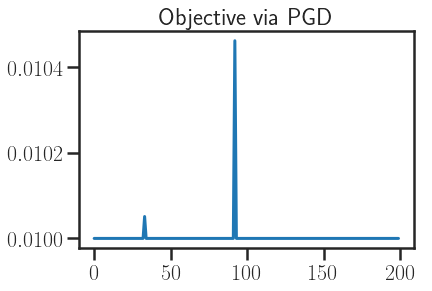

In [57]:
plt.plot(usc_proj_grad );
plt.title("Objective via PGD");

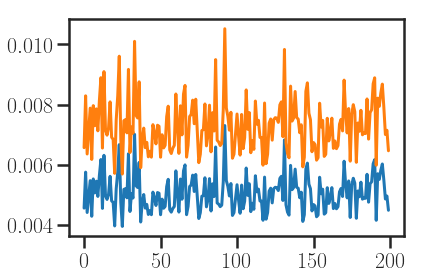

In [14]:
plt.plot(exp_u_star);
plt.plot(usc_proj_grad/1.2);

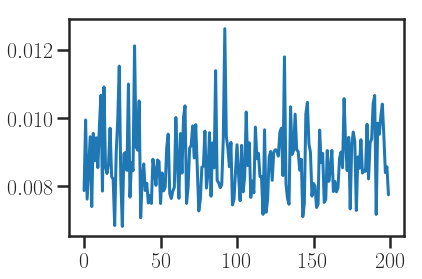

In [15]:
plt.plot(usc_proj_grad);

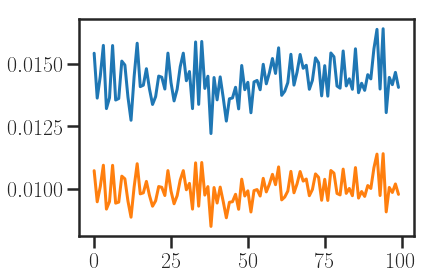

In [16]:
plt.plot(exp_v_star);
plt.plot(vsc_proj_grad*1.2);

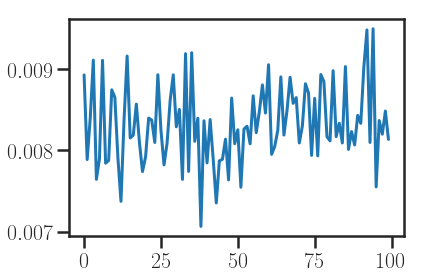

In [17]:
plt.plot(vsc_proj_grad);

### Sort of the solution by `screenkhorn` 

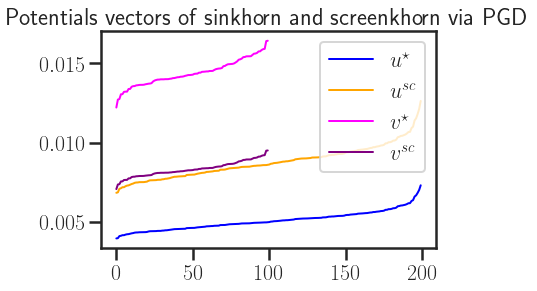

In [18]:
plt.plot(np.sort(exp_u_star), 'blue', linewidth=2, label =r'${u^\star}$')
plt.plot(np.sort(proj_grad["usc"]), 'orange', linewidth=2, label =r'${u^{{sc}}}$')
plt.plot(np.sort(exp_v_star), 'magenta', linewidth=2, label =r'${v^\star}$')
plt.plot(np.sort(proj_grad["vsc"]), 'purple', linewidth=2, label =r'${v^{{sc}}}$')
plt.legend(loc='best');
plt.title(r'Potentials vectors of sinkhorn and screenkhorn via PGD');

### Checking the solutions of Block PDG

In [19]:
# sinkhorn
P_star = np.diag(exp_u_star) @ K @ np.diag(exp_v_star)
a_star = P_star @ np.ones(n_2)
b_star = P_star.T @ np.ones(n_1)

# screenkhorn via pgd
usc_ord = proj_grad["usc"]
vsc_ord = proj_grad["vsc"]
P_sc_ord = np.diag(usc_ord) @ K @ np.diag(vsc_ord)
a_sc_ord = P_sc_ord @ np.ones(n_2)
b_sc_ord = P_sc_ord.T @ np.ones(n_1)

print("sum of the marginals in sinkhorn are: %s, \t %s" %(sum(a_star), sum(b_star)))
print("\t")
print("sum of the marginals in screenkhorn are: %s, \t %s" %(sum(a_sc_ord), sum(b_sc_ord)))
print("\t")
print("Difference in sinkhorn: %s \t %s:" %(abs(1 - sum(a_star)), abs(1 - sum(b_star))))
print("\t")
print("Difference in screenkhorn: %s \t  %s:" %(abs(1 - sum(a_sc_ord)), abs(1 - sum(b_sc_ord))))
print("\t")
print("Frobenius norm of difference solution matrices %s " %np.linalg.norm(P_star - P_sc_ord,'fro'))
print('\t')
print("Max norm of difference solution matrices %s "  %abs(P_star - P_sc_ord).max())

sum of the marginals in sinkhorn are: 1.0000000000000007, 	 1.0000000000000007
	
sum of the marginals in screenkhorn are: 0.9999976062569472, 	 0.999997606256947
	
Difference in sinkhorn: 6.661338147750939e-16 	 6.661338147750939e-16:
	
Difference in screenkhorn: 2.393743052775399e-06 	  2.3937430529974435e-06:
	
Frobenius norm of difference solution matrices 3.979432570509655e-08 
	
Max norm of difference solution matrices 2.528084512023153e-09 


In [20]:
plt.plot(u_star, linewidth=2, color='r', label=r'${u^\star}$')
plt.plot(usc_ord, linewidth=2, color='b', label=r'$u_{sc}$')
plt.legend()
plt.legend();

NameError: name 'u_star' is not defined

In [ ]:
plt.plot(v_star, linewidth=2, color='m', label=r'${u^\star}$')
plt.plot(vsc_ord, linewidth=2, color='g', label=r'$u_{sc}$')
plt.legend()
plt.legend();

## Block Projected Gradient Decsent

In [ ]:
proj_grad_alt = \
screenkhorn.bloc_proj_grad(-3*np.ones(n_1), -3*np.ones(n_2), I, J, max_iter_backtracking=30,
                                 step_size=8., max_iter=1000, tol=1e-10, verbose=False)

In [ ]:
obj_alt= proj_grad_alt["trace_obj"]
plt.plot(obj_alt)
plt.title("Objective via Block PDG");

In [ ]:
figure, axes = plt.subplots(nrows=2, ncols=2)
axes[0,0].plot(np.sort(u_star), 'blue', linewidth=2, label =r'${u^\star}$')
axes[1,0].plot(np.sort(proj_grad_alt["usc"]), 'orange', linewidth=2, label =r'${u^{{sc}}}$')
axes[0,1].plot(np.sort(v_star), 'magenta', linewidth=2, label =r'${v^\star}$')
axes[1,1].plot(np.sort(proj_grad_alt["vsc"]), 'purple', linewidth=2, label =r'${v^{{sc}}}$')

axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend();

# plt.plot(np.sort(u_star), 'blue', linewidth=2, label =r'${u^\star}$')
# plt.plot(np.sort(proj_grad_alt["usc"]), 'orange', linewidth=2, label =r'${u^{{sc}}}$')
# plt.plot(np.sort(v_star), 'magenta', linewidth=2, label =r'${v^\star}$')
# plt.plot(np.sort(proj_grad_alt["vsc"]), 'purple', linewidth=2, label =r'${v^{{sc}}}$')
# plt.axhline(y =np.log(epsilon), linewidth=, color='r', label=r'$\log(\varepsilon)$');
# plt.legend(loc='best');
# plt.title(r'log-potentials vectors of sinkhorn and screenkhorn with ${maxIter}=10000,\,tol=1e-19$')
# plt.title(r'Potentials vectors of sinkhorn and screenkhorn via Block PGD');

### Checking the solutions of Block PDG

In [ ]:
# screenkhorn via block pgd
usc_alt = proj_grad_alt["usc"]
vsc_alt = proj_grad_alt["vsc"]
P_sc_alt = np.diag(np.exp(usc_alt)) @ K @ np.diag(np.exp(vsc_alt))
a_sc_alt = P_sc_alt @ np.ones(n_2)
b_sc_alt  = P_sc_alt.T @ np.ones(n_1)

print("sum of the marginals in sinkhorn are: %s, \t %s" %(sum(a_star), sum(b_star)))
print("\t")
print("sum of the marginals in screenkhorn are: %s, \t %s" %(sum(a_sc_alt), sum(b_sc_alt)))
print("\t")
print("Difference in sinkhorn: %s \t %s:" %(abs(1 - sum(a_star)), abs(1 - sum(b_star))))
print("\t")
print("Difference in screenkhorn: %s \t  %s:" %(abs(1 - sum(a_sc_alt)), abs(1 - sum(b_sc_alt))))

print("\t")
print("Frobenius norm of %s ",  np.linalg.norm(P_star - P_sc_alt,'fro'))
print('\t')
print("Max norm of %s ",  abs(P_star - P_sc_alt).max())

## Accelerated Projected Gradient Descent

In [ ]:
proj_grad_acc = \
screenkhorn.acc_projected_grad(np.zeros(n_1), np.zeros(n_2), I, J, 
                                        max_iter_backtracking=40,
                                        step_size=1e3, max_iter=100, tol=1e-10, verbose=False)

In [ ]:
#plt.yscale("log")
obj_acc= proj_grad_acc["trace_obj"]
plt.plot(obj_acc)
plt.title("Objective via Accelerated PGD");

In [ ]:
plt.plot(np.sort(u_star), 'blue', linewidth=2, label =r'${u^\star}$')
plt.plot(np.sort(proj_grad_acc["usc"]), 'orange', linewidth=2, label =r'${u^{{sc}}}$')
plt.plot(np.sort(v_star), 'magenta', linewidth=2, label =r'${v^\star}$')
plt.plot(np.sort(proj_grad_acc["vsc"]), 'purple', linewidth=2, label =r'${v^{{sc}}}$')
# plt.axhline(y =np.log(epsilon), linewidth=, color='r', label=r'$\log(\varepsilon)$');
plt.legend(loc='best');
# plt.title(r'log-potentials vectors of sinkhorn and screenkhorn with ${maxIter}=10000,\,tol=1e-19$')
plt.title(r'Potentials vectors of sinkhorn and screenkhorn via Acc PGD.pdf');

### Checking the solutions of Block PDG

In [ ]:
# screenkhorn via pgd
usc_acc = proj_grad_acc["usc"]
vsc_acc = proj_grad_acc["vsc"]
P_sc_acc = np.diag(np.exp(usc_acc)) @ K @ np.diag(np.exp(vsc_acc))
a_sc_acc = P_sc_acc @ np.ones(n_2)
b_sc_acc  = P_sc_acc.T @ np.ones(n_1)

print("sum of the marginals in sinkhorn are: %s, \t %s" %(sum(a_star), sum(b_star)))
print("\t")
print("sum of the marginals in screenkhorn are: %s, \t %s" %(sum(a_sc_acc), sum(b_sc_acc)))
print("\t")
print("Difference in sinkhorn: %s \t %s:" %(abs(1 - sum(a_star)), abs(1 - sum(b_star))))
print("\t")
print("Difference in screenkhorn: %s \t  %s:" %(abs(1 - sum(a_sc_acc)), abs(1 - sum(b_sc_acc))))

print("\t")
print("Frobenius norm of %s " %np.linalg.norm(P_star - P_sc_acc,'fro'))
print('\t')
print("Max norm of %s "  %abs(P_star - P_sc_acc).max())

In [ ]:
usc_alt = proj_grad_acc["usc"]
vsc_alt = proj_grad_acc["vsc"]

plt.plot(u_star, linewidth=2, color='r', label=r'${u^\star}$')
plt.plot(usc_acc, linewidth=2, color='b', label=r'$u_{sc}$')
plt.legend()
plt.legend();

In [ ]:
plt.plot(v_star, linewidth=2, color='m', label=r'${v^\star}$')
plt.plot(vsc_acc, linewidth=2, color='g', label=r'$v_{sc}$')
plt.legend()
plt.legend();

In [ ]:
block_acc_proj_grad = \
screenkhorn.block_acc_projected_grad(np.zeros(n_1), np.zeros(n_2), I, J, 
                                        max_iter_backtracking=70,
                                        step_size=50., max_iter=1000, tol=1e-10, verbose=False)

In [ ]:
#plt.yscale("log")
obj_block_acc = block_acc_proj_grad["trace_obj"]
plt.plot(obj_block_acc)
plt.title("Objective via Accelerated PGD");

In [ ]:
plt.plot(np.sort(u_star), 'blue', linewidth=2, label =r'${u^\star}$')
plt.plot(np.sort(block_acc_proj_grad["usc"]), 'orange', linewidth=2, label =r'${u^{{sc}}}$')
plt.plot(np.sort(v_star), 'magenta', linewidth=2, label =r'${v^\star}$')
plt.plot(np.sort(block_acc_proj_grad["vsc"]), 'purple', linewidth=2, label =r'${v^{{sc}}}$')
# plt.axhline(y =np.log(epsilon), linewidth=, color='r', label=r'$\log(\varepsilon)$');
plt.legend(loc='best');
# plt.title(r'log-potentials vectors of sinkhorn and screenkhorn with ${maxIter}=10000,\,tol=1e-19$')
plt.title(r'Potentials vectors of sinkhorn and screenkhorn via Acc PGD.pdf');

In [ ]:
# screenkhorn via pgd
usc_block_acc = block_acc_proj_grad["usc"]
vsc_block_acc = block_acc_proj_grad["vsc"]
P_sc_block_acc = np.diag(np.exp(usc_block_acc)) @ K @ np.diag(np.exp(vsc_block_acc))
a_sc_block_acc = P_sc_block_acc @ np.ones(n_2)
b_sc_block_acc  = P_sc_block_acc.T @ np.ones(n_1)

print("sum of the marginals in sinkhorn are: %s, \t %s" %(sum(a_star), sum(b_star)))
print("\t")
print("sum of the marginals in screenkhorn are: %s, \t %s" %(sum(a_sc_block_acc), sum(b_sc_block_acc)))
print("\t")
print("Difference in sinkhorn: %s \t %s:" %(abs(1 - sum(a_star)), abs(1 - sum(b_star))))
print("\t")
print("Difference in screenkhorn: %s \t  %s:" %(abs(1 - sum(a_sc_block_acc)), abs(1 - sum(b_sc_block_acc))))

print("\t")
print("Frobenius norm of %s " %np.linalg.norm(P_star - P_sc_block_acc,'fro'))
print('\t')
print("Max norm of %s "  %abs(P_star - P_sc_block_acc).max())

In [ ]:
#plt.yscale("log")


In [ ]:
toc / time_sink